[Think Stats Chapter 6 Exercise 1](http://greenteapress.com/thinkstats2/html/thinkstats2007.html#toc60) (household income)

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.

The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from the Census Burea’s website. I downloaded hinc06.xls, which is an Excel spreadsheet with information about household income, and converted it to hinc06.csv, a CSV file you will find in the repository for this book. You will also find hinc2.py, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income "Under \$5,000." The highest range includes respondents who made "\$250,000 or more."

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. hinc2.py provides InterpolateSample, which shows one way to model this data. It takes a DataFrame with a column, income, that contains the upper bound of each range, and freq, which contains the number of respondents in each frame.

It also takes log_upper, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is 106, or one million dollars.”

InterpolateSample generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households reports a taxable income below the mean? How do the results depend on the assumed upper bound?

This notebook has been converted to a markdown file using [convert_notebooks_to_markdown.py](./convert_notebooks_to_markdown.py).


# Answer

Income levels were upsampled assuming a base-10 log-linear relationship. The effect of different upper income levels (\$1,000,000, \$5,000,000, and \$10,000,000) on statistical parameters was determined.

Increasing the only maximum income level during upsampling has the expected effect of increasing mean, skew, and the fraction of households with incomes below the mean. Median is invariant regardless of upper income, which is as expected since only the highest income bin is being changed and the number of samples in this bin does not vary.

Pearson's skew **decreases** when the maximum income level is increased. Conceptually, this is unexpected but the likely explanation is that the standard deviation increase overwhelms the difference between the mean and median. For this reason, Pearson's skew may not be an ideal statistic for determining differences between log-linear data.

In [10]:
print(tabulate(statistics,
               headers=statistics.columns.tolist(),
               tablefmt='pipe',
               floatfmt=".3f")
     )

|                 |   1000000 |    5000000 |   10000000 |
|:----------------|----------:|-----------:|-----------:|
| mean            | 74278.708 |  99117.595 | 124267.397 |
| std             | 93947.314 | 309013.513 | 559610.786 |
| median          | 51226.933 |  51226.933 |  51226.933 |
| skew            |     4.950 |     10.251 |     11.604 |
| pearsons_skew   |     0.736 |      0.465 |      0.392 |
| frac_below_mean |     0.660 |      0.778 |      0.857 |


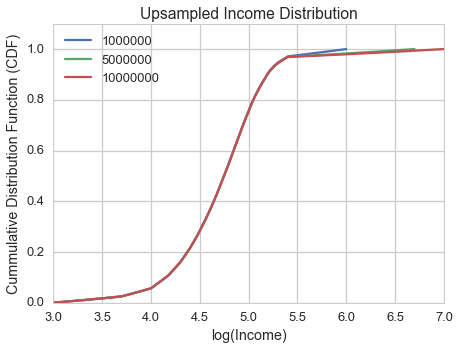

In [11]:
plt.show()

# Code

In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

%matplotlib inline
%config InlineBackend.close_figures = False

The base-10 log values to be used for the upper limit of income. In dollars, these values are: 1,000,000, 5,000,000, and 10,000,000.

In [3]:
log_upper = [6.0, np.log10(5.0e6), 7.0]

## Import and clean data

Income levels have to be parsed and converted to a base-10 logarithmic scale for resampling.

In [4]:
# Import as a dataframe
thinkstats_path = '/Volumes/Files/datascience_books/ThinkStats2/code'

data = pd.read_csv(os.sep.join([thinkstats_path, 'hinc06.csv']), 
                   header=None, skiprows=9, 
                   names=['income_str','freq'], usecols=[0,1])

# Fix column formatting, determine lower and upper limit for income in each bracket
data['freq'] = data.freq.str.replace(',','').astype(int)

data['income_low'] = ( data.income_str
                .str.extract(r"""([0-9,]+)""", expand=False)
                .str.replace(',','')
                .astype(float)
              )

data['income_high'] = (data.income_low.shift(-1) - 1).fillna(np.inf)
data.drop(['income_str','income_low'], axis=1, inplace=True)

# Log scale conversion
data['log_upper'] = np.log10(data.income_high)
data['log_lower'] = data.log_upper.shift(1).dropna()

# Lowest yearly income amount is set to $1000 (i.e. 10**3)
data.loc[0, 'log_lower'] = 3.0 

## Upsample data

Resample the data using a log-linear distribution.

In [5]:
# The resampling function
def freq_upsampler(df, log_upper=None):
        
    # Expanding # of rows only works on Series
    series = df.squeeze()
    
    if not np.isinf(series.log_upper):
        log_upper = series.log_upper
        
    resampled_data =  pd.DataFrame({'log_income': np.linspace(series.log_lower, 
                                                              log_upper, 
                                                              series.freq)})
    return resampled_data


resampled_data = map(lambda y: ( data.groupby(level=0, group_keys=False)
                                 .apply(lambda x: freq_upsampler(x, y))
                                ), log_upper)

resampled_data = pd.concat(resampled_data, axis=1)

resampled_data.columns = map(lambda x: int(np.round(10**x, 0)), log_upper)

## Compute statistical parameters

Compute statistics (mean, median, skew, Pearson's median skew) on the results. Note that the data must be converted from their logarithmic form.

Pearson's median skew is:
$$g_p = \frac{3(\bar{x} - m)}{S}$$

In [6]:
def pearsons_skew(data):
    return 3.0*(data.mean() - data.median()) / data.std()

def frac_below_mean(data):
    return (data < data.mean()).sum() / float(data.shape[0])

statistics = ( (10**resampled_data)
              .stack()
              .groupby(level=-1)
              .agg(['mean', 'std', 'median', 'skew', pearsons_skew, frac_below_mean])
             ).T

In [7]:
print(tabulate(statistics,
               headers=statistics.columns.tolist(),
               tablefmt='pipe',
               floatfmt=".3f")
     )

|                 |   1000000 |    5000000 |   10000000 |
|:----------------|----------:|-----------:|-----------:|
| mean            | 74278.708 |  99117.595 | 124267.397 |
| std             | 93947.314 | 309013.513 | 559610.786 |
| median          | 51226.933 |  51226.933 |  51226.933 |
| skew            |     4.950 |     10.251 |     11.604 |
| pearsons_skew   |     0.736 |      0.465 |      0.392 |
| frac_below_mean |     0.660 |      0.778 |      0.857 |


## Visualize income distributions
Plot the log distribution of income relative to the CDF.

In [8]:
cdf = resampled_data.cumsum() / resampled_data.sum()
combined_data = pd.concat([resampled_data, cdf], axis=1)
combined_data.columns = pd.MultiIndex.from_product([['income', 'cdf'], resampled_data.columns])

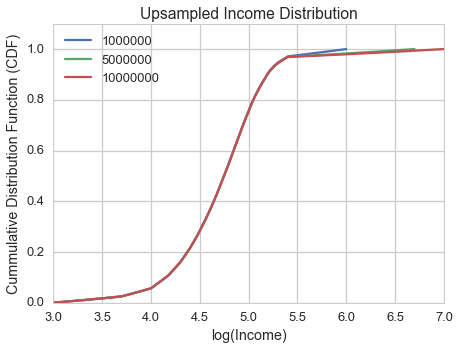

In [9]:
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure()
fig.set_size_inches(7, 5)

ax = plt.axes()

_ = combined_data.stack().groupby(level=-1).plot('income', 'cdf', kind='line', ax=ax)

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, combined_data.columns.get_level_values(1).unique(), loc=0)
_ = ax.set_ylim(0, 1.1)
_ = ax.set_xlabel('log(Income)')
_ = ax.set_ylabel('Cummulative Distribution Function (CDF)')
_ = ax.set_title('Upsampled Income Distribution')